# Challenge
Unit 3 / Lesson 4 / Project 4

We're going to look at recipes.
Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating.

Transform this regression problem into a binary classifier and clean up the feature set.
You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate might just be happier people.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes).

In [2]:
PATH =('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv'
)
# set title column as index
raw_data = pd.read_csv(PATH, index_col=0)
raw_data.head()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visual EDA

In [3]:
#list(raw_data.columns)

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

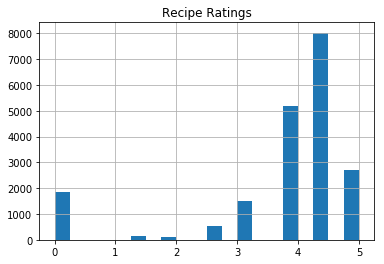

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Recipe Ratings')
plt.show()

### Clean Data
Let's see if we can transform the distribution of the rating data.

In [6]:
# perform log transformation on ratings
raw_data['log_rating'] = np.log1p(raw_data['rating'])
raw_data['log_rating'].describe()

count    20052.000000
mean         1.468796
std          0.487763
min          0.000000
25%          1.558145
50%          1.681759
75%          1.681759
max          1.791759
Name: log_rating, dtype: float64

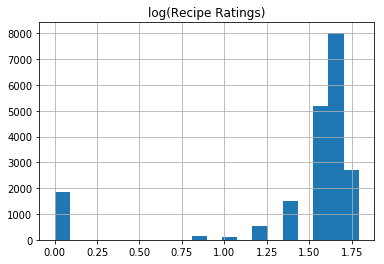

In [7]:
raw_data.log_rating.hist(bins=20)
plt.title('log(Recipe Ratings)')
plt.show()

That's better. Now the distribution of the ratings data looks more like a binomial distribution.
We can see that the data clusters at either 0 or above 1.5.

We can now convert our log(ratings) data to a binary feature where any rating over 1.5 is a 'high rating' and anything below it is a 'low rating'

In [8]:
# define binary 'high rating' feature
raw_data['high_rating'] = np.where(
    raw_data['log_rating'] > 1.5, 1, 0
)

raw_data['high_rating'].value_counts()

1    15907
0     4145
Name: high_rating, dtype: int64

### Feature Selection

Now that our ratings data is ready to go, let's select our features.

Let's take the sum of each feature (excluding ratings and nutritional info), as each feature is binary and the sum will represent the frequency of those ingredients showing up in recipes.

In [18]:
drop_list = ['rating', 'log_rating',
             #'log_calories', 'log_protein', 'log_fat', 'log_sodium',
             'calories', 'protein', 'fat', 'sodium'
            ]
features = raw_data.drop(drop_list, axis=1)

data = features.drop('high_rating', axis=1)
target = features['high_rating']

In [74]:
# import select kbest
# select top 30 features
#from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

display(data.shape)
classifier = SelectKBest(chi2, k=30).fit(data, target)

(20052, 674)

In [75]:
# Create new dataframe with only desired columns, or overwrite existing
feature_names = list(data.columns.values)

# Get columns to keep
mask = classifier.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(cols, feature_names):
    if bool:
        new_features.append(feature)
        
data_new = data[new_features]
data_new.head()

,alcoholic,bake,bitters,bon appétit,brandy,cocktail,cocktail party,condiment,créme de cacao,drink,...,roast,rum,sauté,soy free,spirit,tomato,tree nut free,vegan,weelicious,winter
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Boudin Blanc Terrine with Red Onion Confit,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Potato and Fennel Soup Hodge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mahi-Mahi in Tomato Olive Sauce,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
Spinach Noodle Casserole,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we have the most frequently occuring ingredients as our feature list.

Let's make sure there's no correlation between our features.

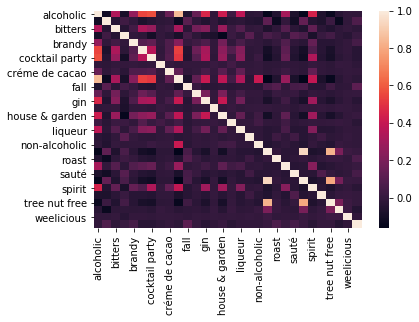

In [76]:
# plot a heatmap
sns.heatmap(data_new.corr());

It looks like we have some correlated features.
Let's drop anything with over a 90% correlation.

In [77]:
# Create correlation matrix
corr_matrix = data_new.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

display(data_new.shape)

# Drop correlated features 
for i in to_drop:
    data_new = data_new.drop(i, axis=1)

data_new.shape

(20052, 30)

(20052, 29)

Now we've dropped our correlated features and we're ready to model.

### Model Data

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_new, target, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
# Declare a logistic regression classifier.
lr = LogisticRegression()

# Fit the model.
fit = lr.fit(X_train,y_train)

# Display.
print('Logistic Regression')
print('\nAccuracy training set:')
print(lr.score(X_train, y_train))

#Store the parameter estimates.
origparams = np.append(lr.coef_, lr.intercept_)
#print('\nParameter estimates:')
#print(origparams)

print('\nAccuracy test set:')
print(lr.score(X_test, y_test))

C:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression

Accuracy training set:
0.8035035222243002

Accuracy test set:
0.8110196958364497


Excellent, our binary classifier has a consistent accuracy across both the training and test sets.

### Conclusion

In [81]:
print(data_new.columns.values)

['alcoholic' 'bake' 'bitters' 'bon appétit' 'brandy' 'cocktail'
 'cocktail party' 'condiment' 'créme de cacao' 'drink' 'fall'
 'fortified wine' 'gin' 'harpercollins' 'house & garden' 'lime juice'
 'liqueur' 'low carb' 'non-alcoholic' 'peanut free' 'roast' 'rum' 'sauté'
 'spirit' 'tomato' 'tree nut free' 'vegan' 'weelicious' 'winter']


Our binary classifier had approximately an 80% accuracy of predicting a high rating recipe based on our top 30 recipe ingredients.

This means that we could make an informed recommendation to someone writing a blog, cookbook, or website about the topics to include to maximize web traffic or review ratings.

Our classifier doesn't address potential bias in our model, though.
We did randomly select our training and test sets, which can reduce bias and overfitting.
Though it doesn't account for bias in the data collection method.

In order to review a recipe, a user has to 'opt in', they can just as easily choose not to review the recipe.
Therefore the reviewer must have a strong motivation, either positive or negative, to take time to rate a recipe.
We can see this in the binary nature of the recipe reviews.
The data was skewed to either extreme; recipes either received a high rating or a rating of 0.

It's likely that the binary nature of the data biased the feature selection process.
We can see that many of the features are dietary-specific, such as allergies (peanut, soy, tree nut, gluten) and dietary restrictions (kosher, no sugar added, pescatarian).
It's possible people seeking this type of information are more likely to give a positive review to a recipe specific to their dietary needs rather than someone seeking a recipe to use up their leftover onions sitting in their pantry.

This isn't totally useless information, though.
Instead of recommending a static list of recipe ingredients for an author or blogger, we could recommend a list of topics to build recipes around.
For example, a cookbook or blog dedicated to allergy-specific recipes, or a recipe list to use up pantry staples.

If we wanted to fine tune our model even more, we could categorize our features based on type.
Group allergens together, fresh ingredients such as fruits and vegetables together, and recipe descriptors such as 'kid-friendly' or 'vegan'.
Then we can get could possibly adjust for bias in the data collecting methods, as recipes containing chocolate won't out rank recipes for raw, vegan, no bake gluten free fiber bars and vice versa.